### 말하기 및 듣기의 주제 변환 효과
말을 할 때, 그리고 들을 때의 topic boundary effect를 확인해본다.  
하기 전에 `/Free_Speech/Speech/_data_Project/speech_3T/project_info.json` & `speech_3T_v2/project_info.json`의 bids_path, audio_path를 `/Free_Speech/speech_3T/_DATA_fMRI`, `/Free_Speech/speech_3T/_DATA_Audio`의 경로로 수정한다.  
그리고 `/sas2/PECON/HK/speech_3T`를 `/Free_Speech/Speech/speech_3T`에 붙여넣는다.

</br>
</br>
미리 주어진 3개의 주제에 대해서 말 할때 & 들을 때의 주제 변환 시점 BOLD signal을 관찰해본다.

In [1]:
import numpy as np
from Speech.load_project_info import get_good_sub

# 피험자 정보를 불러온다.
# 실험을 중간에 수정해서 버전이 약간 달라서 둘 다 불러온다.
Projects = ["speech_3T", "speech_3T_v2"]
Project_tasks = {"speech_3T": ["speechTOPIC_run-1", "listeningTOPIC"], 
                 "speech_3T_v2": ["speechTOPIC", "listeningTOPIC"]}

sub_infos = []
for Project in Projects:
    tasks = Project_tasks[Project]
    speech_sub = get_good_sub(Project, target_run=tasks[0])
    listening_sub = get_good_sub(Project, target_run=tasks[1])
    
    # 말하기 & 듣기 모두 데이터 상태가 좋은 피험자만 사용한다.
    subs = list(set(speech_sub)&set(listening_sub))
    subs.sort()
    
    for sub in subs: sub_infos.append([Project, sub])

sub_infos
    

[['speech_3T', '001'],
 ['speech_3T', '002'],
 ['speech_3T', '003'],
 ['speech_3T', '004'],
 ['speech_3T', '005'],
 ['speech_3T', '007'],
 ['speech_3T', '008'],
 ['speech_3T', '009'],
 ['speech_3T', '010'],
 ['speech_3T_v2', '012'],
 ['speech_3T_v2', '013'],
 ['speech_3T_v2', '015'],
 ['speech_3T_v2', '018'],
 ['speech_3T_v2', '019']]

In [2]:
# Atlas는 Brannetome을 이용한다.
## roi
from Speech import tools_EPI
ROIs = {
    "Hipp":[215,216,217,218],
    "AG": [143,144],
    "PMC": [153,154,175,176],
    "ACC": [187,188],
    "dlPFC": [21,22],
    "Aud": [73,74] 
}
atlas = tools_EPI.get_atlas("Brainnetome")[1]

In [3]:
# epi를 미리 불러온다.
epi_speech = []
epi_listening = []
for info in sub_infos:
    sub = info[1]
    Project = info[0]
    print("load epi sub-"+sub)
    # zscoring 된 상태로 불러온다.
    epi_speech.append(tools_EPI.loader(Project, sub, Project_tasks[Project][0]))
    epi_listening.append(tools_EPI.loader(Project, sub, Project_tasks[Project][1]))

load epi sub-001
load epi sub-002
load epi sub-003
load epi sub-004
load epi sub-005
load epi sub-007
load epi sub-008
load epi sub-009
load epi sub-010
load epi sub-012
load epi sub-013
load epi sub-015
load epi sub-018
load epi sub-019


위에서 언급한 ROI의 mean BOLD를 각각 구해서 그린다.  
- Topic boundary: 주제 3개 변경 시점
- Sentence boundary: 문장 종료 시점 중 주제 변경 시점의 평균 말 쉬는 시간과 가장 가깝게 말 쉬는, topic boundary 개수와 동일한 개수만큼 뽑은 문장 종료 시점

Target roi: Hipp
Target roi: AG
Target roi: PMC
Target roi: ACC
Target roi: dlPFC
Target roi: Aud


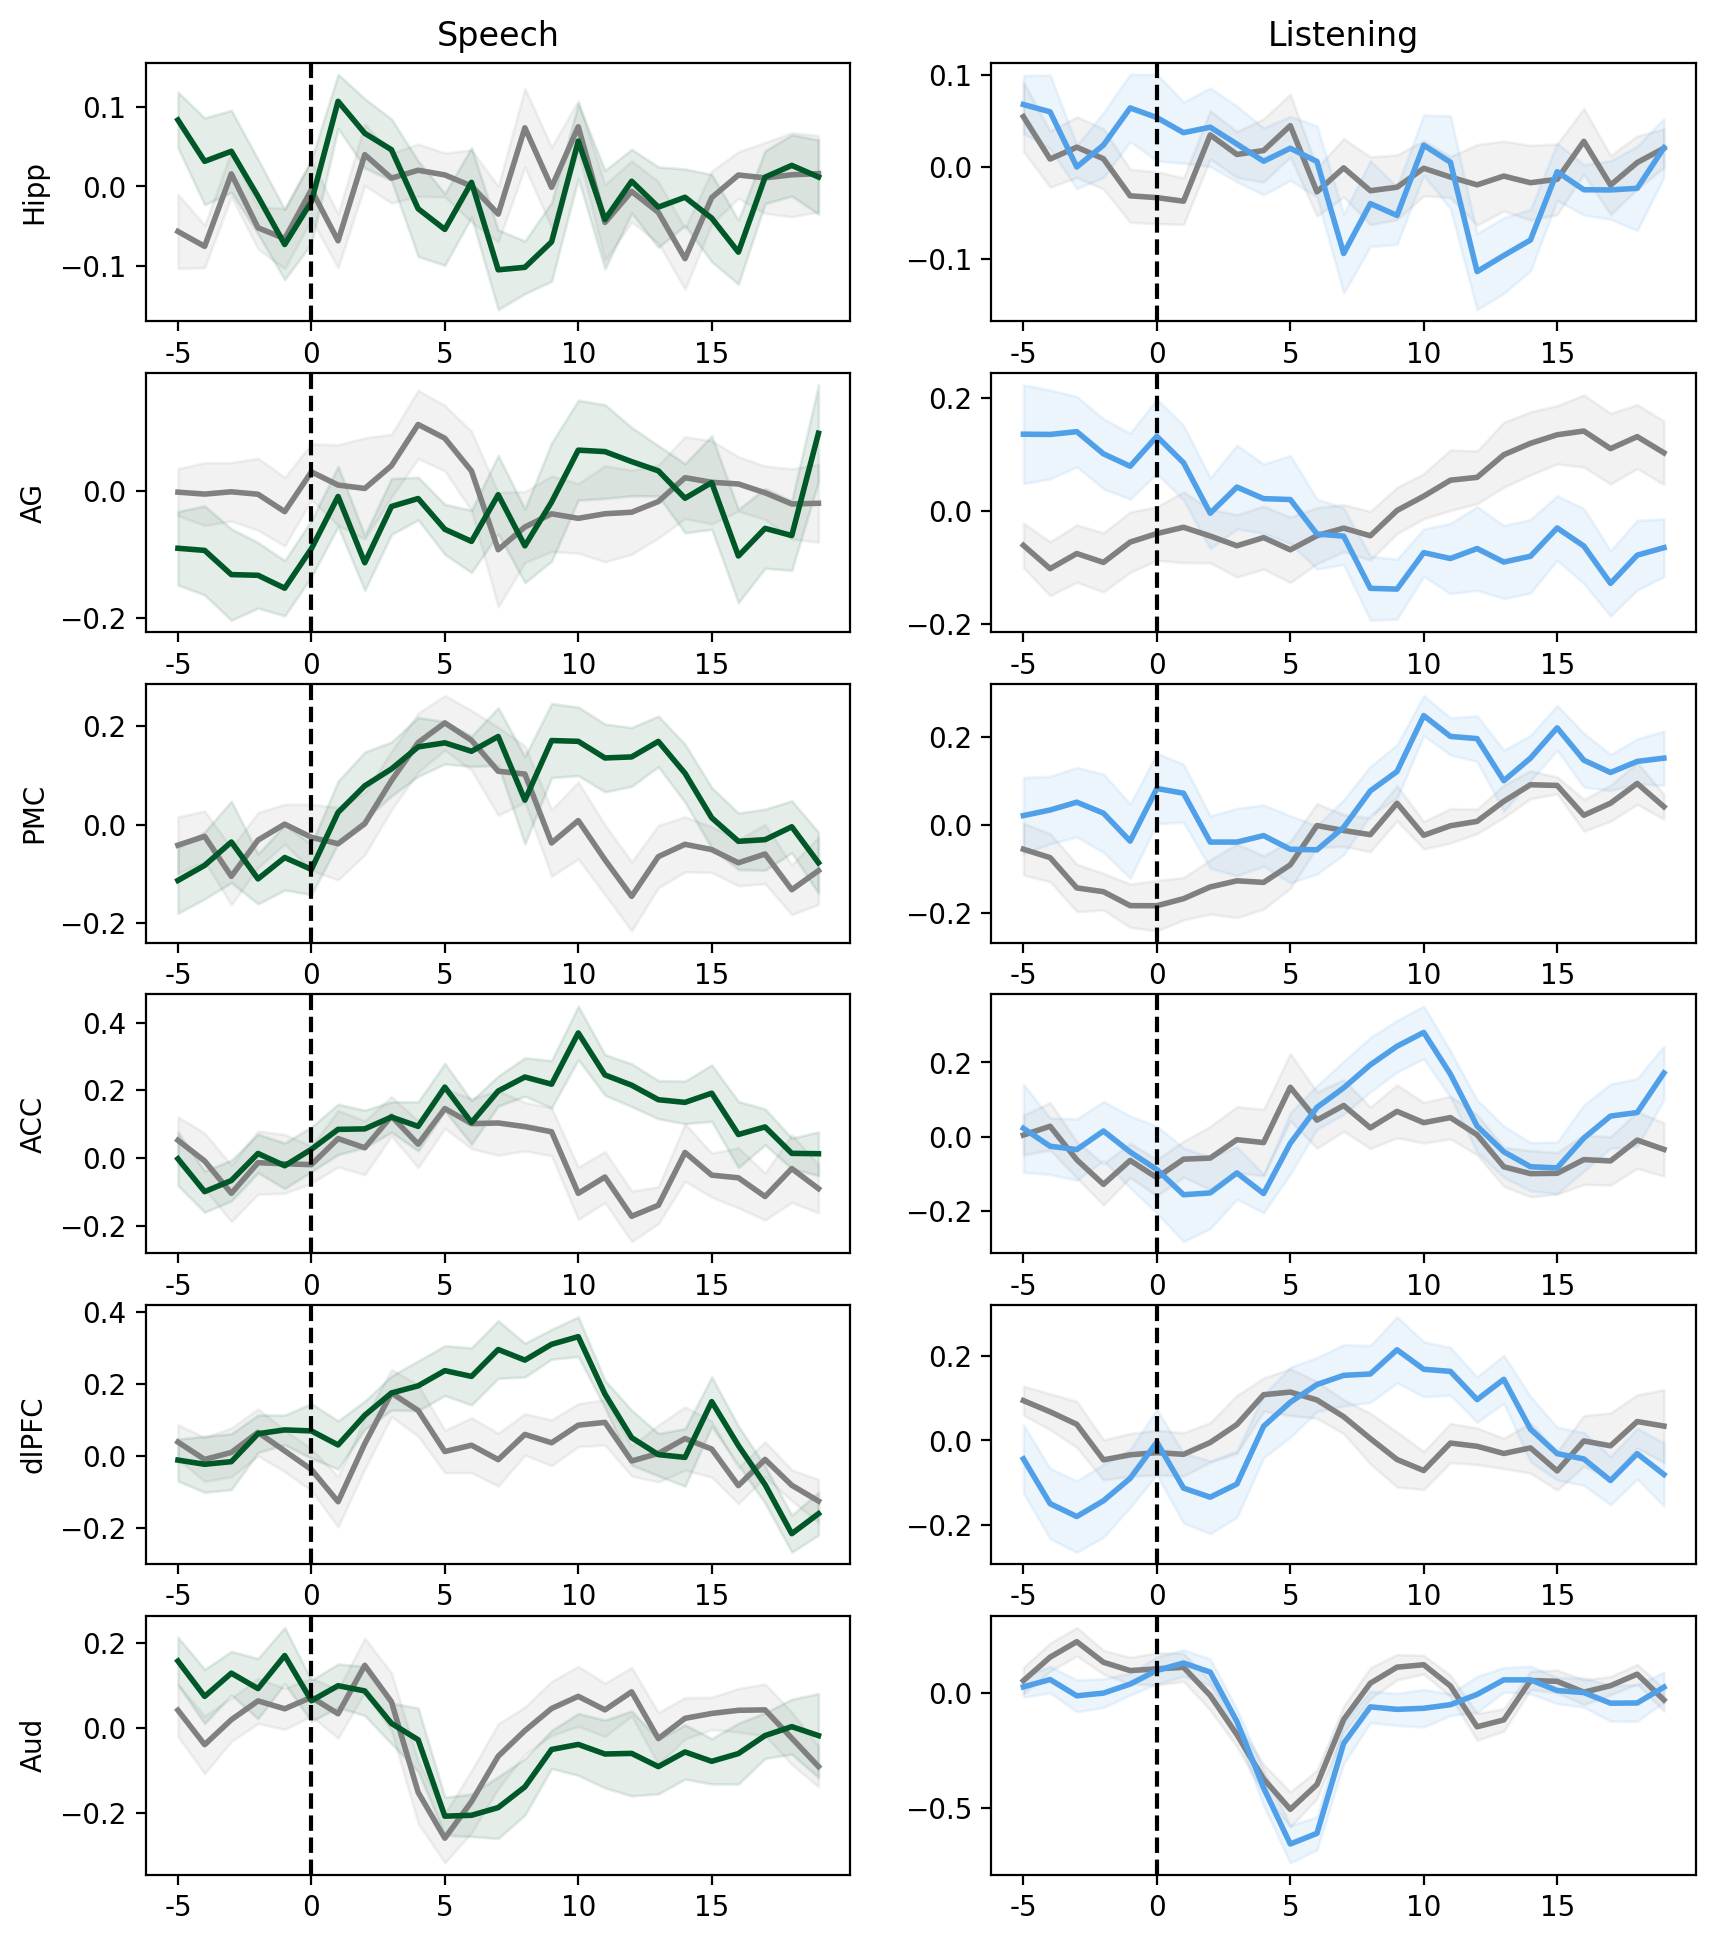

In [5]:
# 각 ROI마다 BOLD 평균 구하고 플롯
import matplotlib.pyplot as plt
from Speech.tools_Plot import timeseries_with_error
from Speech.tools_Text import load_audio_boundary


# plot 범위
window_l = 5    # -5 TR부터
window_r = 20   # +20 TR까지


plt.figure(figsize=(10,2*len(ROIs.keys())), dpi=200)

for n, target_roi in enumerate(ROIs.keys()): # roi마다 진행
    print("Target roi: "+target_roi)
    
    # roi mask 생성
    roi = np.zeros(atlas.shape)
    for number in ROIs[target_roi]: 
        roi = np.logical_or(roi, atlas==number)
        
    # 주제 변환 시점과 그 비교군으로 문장 변환 시점을 사용한다.
    speech = []
    speech_sen = []
    listening = []
    listening_sen = []
    
    # 각 피험자마다
    for sub_number, info in enumerate(sub_infos):
        sub = info[1]
        Project= info[0]
        speech_task =  Project_tasks[Project][0]
        listening_task = Project_tasks[Project][1]
        
        # speech EPI
        epi = epi_speech[sub_number]
        epi_roi = np.nanmean(epi[roi,:], axis=0)
        
        # speech의 주제 변환 시점
        ev = load_audio_boundary(Project, sub, speech_task, 'ev1')
        ev = ev[(ev>window_l)&(ev<(len(epi_roi)-window_r))]
        sub_bound = []
        for t in ev:
            sub_bound.append(epi_roi[t-window_l:t+window_r])      
        speech.append(np.array(np.mean(sub_bound,axis=0))) 
        
        # speech의 문장 종료 시점 
        sen = load_audio_boundary(Project, sub, speech_task, 'sen_limited')
        sen = sen[(sen>window_l)&(sen<(len(epi_roi)-window_r))]
        sub_bound = []
        for t in sen:
            sub_bound.append(epi_roi[t-window_l:t+window_r])      
        speech_sen.append(np.array(np.mean(sub_bound,axis=0))) 
    
    
        # listening EPI 
        epi = epi_listening[sub_number]
        epi_roi = np.nanmean(epi[roi,:], axis=0)
        
        
        listening_task = listening_task.split("_")[0]
        # listening의 주제 변환 시점
        ev = load_audio_boundary(Project, '000', listening_task, 'ev1')+10
        ev = ev[(ev>window_l)&(ev<(len(epi_roi)-window_r))]
        sub_bound = []
        for t in ev:
            sub_bound.append(epi_roi[t+-window_l:t+window_r])      
        listening.append(np.array(np.mean(sub_bound,axis=0)))   
        
        # listening의 문장 종료 시점
        sen = load_audio_boundary(Project, '000', listening_task, 'sen_limited')+10
        sen = sen[(sen>window_l)&(sen<(len(epi_roi)-window_r))]
        sub_bound = []
        for t in sen:
            sub_bound.append(epi_roi[t+-window_l:t+window_r])      
        listening_sen.append(np.array(np.mean(sub_bound,axis=0)))   
       
                     
    speech = np.array(speech)
    speech_sen = np.array(speech_sen)
    listening = np.array(listening)
    listening_sen = np.array(listening_sen)
    
    
    plt.subplot(len(ROIs.keys()), 2, n*2+1)
    timeseries_with_error(speech_sen.T, color=[0.5,0.5,0.5], fill=True, linewidth=2)
    timeseries_with_error(speech.T, color=[0,88/255,40/255], fill=True, linewidth=2)
    plt.xticks(np.arange(0,window_r+window_l,5), np.arange(-window_l, window_r, 5))
    plt.ylabel(target_roi)
    plt.axvline(window_l, color="k", linestyle="--")
    if n==0:
        plt.title("Speech")

    plt.subplot(len(ROIs.keys()), 2, n*2+2)
    timeseries_with_error(listening_sen.T, color=[0.5,0.5,0.5], fill=True, linewidth=2)
    timeseries_with_error(listening.T, color=[80/255,160/255,233/255], fill=True, linewidth=2)
    plt.xticks(np.arange(0,window_r+window_l,5), np.arange(-window_l, window_r, 5))
    plt.axvline(window_l, color="k", linestyle="--")
    if n==0:
        plt.title("Listening")

    